# What are Word Embeddings?

*"A word is characterized by the company it keeps"* - John Rupert Firth

Word embeddings are:
- Representation of words in the form of a real-valued vector.
- Vector encodes the meaning of the word - the words that are closer in the vector space are expected to be similar in meaning.
- Multiple methods to generate this mapping (e.g. neural networks, dimensionality reduction on the word co-occurrence matrix, probabilistic models).

## A short history of word embeddings

## Word embeddings

### word2vec
*"We find that these representations are surprisingly good at capturing syntactic and semantic regularities in language, and that each relationship is characterized by a relation-specific vector offset. This allows vector-oriented reasoning based on the offsets between words. For example, the male/female relationship is automatically learned, and with the induced vector representations, 'King – Man + Woman' results in a vector very close to 'Queen.'"*
- Mikolov, T., Yih, W.T. and Zweig, G., 2013, June. Linguistic regularities in continuous space word representations. In Proceedings of the 2013 conference of the north american chapter of the association for computational linguistics: Human language technologies (pp. 746-751).

Here, we will use the Gensim implementation of word2vec.
You can find the documentation [here](https://radimrehurek.com/gensim/models/word2vec.html).

In [26]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, window=5, min_count=1, workers=4)

vector = model.wv['computer']  # get numpy vector of a word
sims = model.wv.most_similar('computer', topn=5)

print(f"The most similar words to our query word 'computer' are: {sims}")

The most similar words to our query word 'computer' are: [('interface', 0.18933436274528503), ('trees', 0.1504059135913849), ('time', 0.10774273425340652), ('system', 0.08256977796554565), ('human', 0.07860937714576721)]


If a word is out-of-vocabulary, we can save the model and keep training it.

In [12]:
sentences = [['engineering', 'enzyme']]
# train model
model_eng = Word2Vec(sentences, min_count=1)
vector = model_eng.wv['engineering']

Let's plot the word vectors!

C:\Users\fiacac\AppData\Local\Temp/ipykernel_35776/2860803289.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


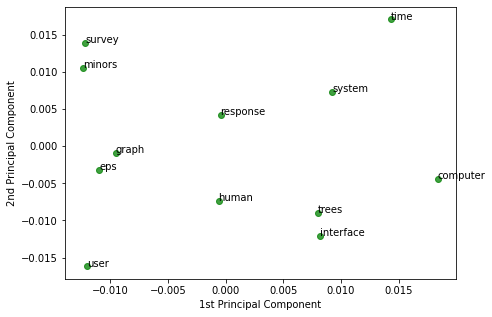

In [23]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Create a scatter plot of the projection
plt.figure(figsize=(7, 5))
plt.scatter(result[:, 0], result[:, 1], color='green', alpha=0.75)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.show()

If you want a more interactive visualization, you can save the vectors and relative labels and upload them in the [Tensorflow Embedding Projector](https://projector.tensorflow.org/), so that you can spin them around and use different dimansionality reduction methods, such as T-SNE, U-MAP or a custom one.

### fasttext

You can find the official documentation [here](https://fasttext.cc/docs/en/support.html).

There, you can find different tutorials, such as for [text classification](https://fasttext.cc/docs/en/supervised-tutorial.html) and for [word representation](https://fasttext.cc/docs/en/unsupervised-tutorial.html). The tutorials are very intuitive, so we will not break down the code here, but you are welcome to reach out to us in case you had any doubts or wanted to explore further use cases.

## Contextual Embeddings

Although approaches such as word2vec have revolutionized NLP practice, they have some limitation: the learned vectors are unique per word, meaning that the word *"batch"*, although might have different meanings, has only one embedding. 

In this example, we will use [BERT](https://arxiv.org/abs/1810.04805).
Please consider taking some time to read the paper and understand its impact on the field.

Now, we can look at an example of how to extract word vectors with BERT.
The following code is inspired by this [tutorial](https://medium.com/mlearning-ai/getting-contextualized-word-embeddings-with-bert-20798d8b43a4).

In [30]:
from transformers import BertModel, BertTokenizer

# First, we load the pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [30]:
def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    return tokenized_text, tokens_tensor, segments_tensor

def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation id disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]
    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)
    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)
    # intialized list to store embeddings
    token_vecs_sum = []
    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence
    # loop over tokens in sentence
    for token in token_embeddings:
    # "token" is a [12 x 768] tensor
    # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    return token_vecs_sum

Now let's define some sentences that contain the word "batch" with can assume various meaning according to the context its used in.

In [35]:
from collections import OrderedDict

sentences = ["batch",
         "the experiment ran for 12 batches.",
         "to train the machine learning model, the dataset should be split into batches.",
         "The cook brought in a fresh batch of homemade cupcakes.",
         "We looked at the job applications in two batches.",
         "Batch processes are used for manufacturing higher value products, such as specialty chemicals, pharmaceuticals and structured products",
         "Batch processes are used widely in the chemical, biochemical materials, pharmaceutical and agricultural industries.",
         "A batch operation is one in which the operating conditions change over time.",
         "A batch operation is performed in a system where all necessary medium components and the inoculum are added at the beginning of the culture.",
         "Batch size is a term used in machine learning and refers to the number of training examples utilised in one iteration.",
         "batch mode: where the batch size is equal to the total dataset thus making the iteration and epoch values equivalent.",
         "mini-batch mode: where the batch size is greater than one but less than the total dataset size. Usually, a number that can be divided into the total dataset size.",
         "tochastic mode: where the batch size is equal to one. Therefore the gradient and the neural network parameters are updated after each sample.."
         ]

context_embeddings = []
context_tokens = []
for sentence in sentences:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    # make ordered dictionary to keep track of the position of each word
    tokens = OrderedDict()
    # loop over tokens in sensitive sentence
    for token in tokenized_text[1:-1]:
    # keep track of position of word and whether it occurs multiple times
        if token in tokens:
            tokens[token] += 1
        else:
            tokens[token] = 1
        # compute the position of the current token
        token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
        current_index = token_indices[tokens[token]-1]
        # get the corresponding embedding
        token_vec = list_token_embeddings[current_index]

        # save values
        context_tokens.append(token)
        context_embeddings.append(token_vec)

## Sentence embeddings

Probably in many cases, word embeddings are not enough to create a representation of your text, since documents are often long and elaborate. There are already implemented methods to convert sentences into vectors, such as the [Sentence Transformer](https://www.sbert.net/).

Let's see how to use this model.

In [3]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

with open('chemical_engineering.txt', 'r') as f:
    file = (f.readlines())

In [34]:
sentence = ''.join(file[0].split('.')[2:3])
vector = model.encode(sentence, convert_to_tensor=True)

# Uncomment below to print the sentence, its sentence embedding and the shape oof the embedding
#print(f"This is the original sentence: {sentence}")
#print(f"The sentence was converted to this vector: {vector}")
#print(f"The shape of the sentence embedding is: {vector.shape[0]} dimensions")

### Operations with word (or sentence) embeddings

Now, we could for example use the vector for calculate the cosine similarity between sentences.

In [32]:
import numpy as np

# Let's first create a list of sentences
list_sentences = file[0].split('.')

# Create an empty list where we will store the similarity scores
list_similarities = []
for sent1 in list_sentences[0:1]:
    embedding_1 = model.encode(sent1, convert_to_tensor=True)
    for sent2 in list_sentences[1:]:
        embedding_2 = model.encode(sent2, convert_to_tensor=True)
        # Similarity of two sentences
        similarity = util.pytorch_cos_sim(embedding_1, embedding_2)[0].numpy()
        sim = round(similarity[0]*100)
        list_similarities.append(sim)  

print(f"Highest cosine similarity between the first sentence and the other: {np.max(list_similarities)}")
print(f"Index of the most similar sentence: {list_similarities.index(np.max(list_similarities))}")

Highest cosine similarity between the first sentence and the other: 82
Index of the most similar sentence: 3


## Nice to know and additional resources

### NLP Holy Grail

If you are looking for a complete, practical, "from zero to hero" book on NLP, we recommend [Speech and Language Processing by Jurafsky and Martin](https://web.stanford.edu/~jurafsky/slp3/).

### Multilingual embeddings

Documents are often multilingual, and therefore models have to adapt to this need.

Hugging Face has a collection of multilingual models available [here](https://huggingface.co/docs/transformers/multilingual). These models have been trained on massive datasets in many languages, and therefore are can be used to solve tasks that are not only in English.

Additionally, another model worth mentioning is [LASER](https://engineering.fb.com/2019/01/22/ai-research/laser-multilingual-sentence-embeddings/), from Meta, which performs zero-shot transfer across 93 languages.